In [ ]:
#----Eliminating warnings from scikit-learn
def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn

import numpy as np
import time
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


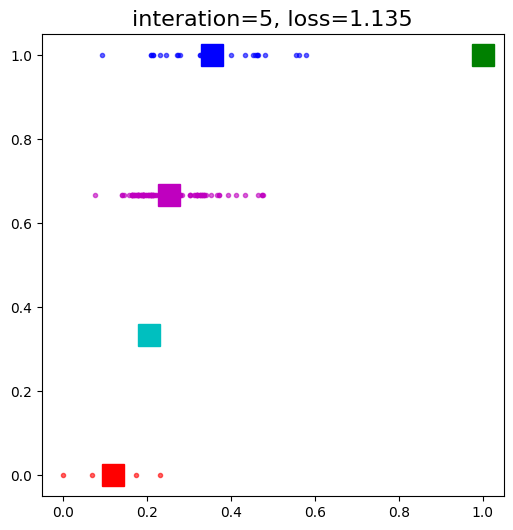

Press Enter to continue
Elapsed time is 11.544584 seconds 



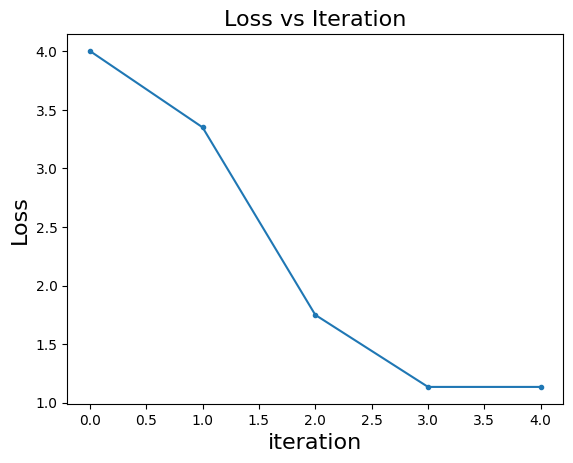

Saved ClusterCars.csv
Saved ClusterAccuracy.csv
Press Enter to end


In [ ]:
def get_data(number_of_samples=None):

    # ---- Read training data
    df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AllCars.csv")

    # ---- Ensure required columns exist
    required = ["Volume", "Doors", "Style"]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns {missing}. Found columns: {list(df.columns)}")

    # ---- Only use Volume and Doors as features
    df["Volume"] = pd.to_numeric(df["Volume"], errors="coerce")
    df["Doors"]  = pd.to_numeric(df["Doors"], errors="coerce")
    df["Style"]  = df["Style"].astype(str)

    # ---- Drop any rows with missing Volume/Doors
    df = df.dropna(subset=["Volume", "Doors"]).reset_index(drop=True)

    # ---- Normalize Data
    all_samples = df[["Volume", "Doors"]].to_numpy(dtype=float)
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    all_samples = scaler.fit_transform(all_samples)
    styles = df["Style"]

    # ---- Plot the data points (just as a scatter)
    figure, plot_area = plt.subplots(figsize=(6,6))
    plot_area.plot(all_samples[:,0], all_samples[:,1], 'ko', alpha=0.35)
    plot_area.set_aspect('equal')
    plot_area.set_title('Car data points (Volume vs Doors)', fontsize=16)
    plt.draw()
    plt.show()
    plt.close()

    return all_samples, styles, df
#--------------------------------------------------------------------------------------------------
def get_initial_clusters(K, all_samples):

    #----Create a random number generator
    random_number_generator = np.random.RandomState()

    #----Initialize centers INSIDE the data range (instead of hard-coding 0..6)
    mins = all_samples.min(axis=0)
    maxs = all_samples.max(axis=0)
    initial_clusters = random_number_generator.rand(K,2) * (maxs - mins) + mins

    #----Show initial centers and data
    figure, plot_area = plt.subplots(figsize=(6,6))
    plot_area.plot(all_samples[:,0], all_samples[:,1], 'ko', alpha=0.25)

    colors = ['rs', 'bs', 'gs', 'cs', 'ms']  # 5 clusters
    for cluster_number in range(0, K):
        plot_area.plot(initial_clusters[cluster_number,0],
                       initial_clusters[cluster_number,1],
                       colors[cluster_number], markersize=10)

    plot_area.set_aspect('equal')
    plot_area.set_title('Initialization', fontsize=20)
    plt.draw()
    plt.show()
    plt.close()

    return initial_clusters
    #--------------------------------------------------------------------------------------------------
#----Update the centers in a loop
def iterative_cluster(K, all_samples, initial_cluster_centers):

    #----Interactive mode for plotting in a loop
    plt.ion()
    cluster_centers = initial_cluster_centers.copy()
    cluster_centers_old = initial_cluster_centers.copy()

    #----Time recorder
    tic = time.time()
    loss_list = []
    figure, plot_area = plt.subplots(figsize=(6,6))

    all_samples_norm = np.sum(all_samples**2, axis=1).reshape(-1,1)

    #----Random generator (fixes rng bug from the template)
    rng = np.random.RandomState()

    interation = 0
    while True:

        if interation > 0:
            difference = (cluster_centers - cluster_centers_old)**2
            difference = difference.sum()

            if difference < 1e-10:
                break

        #----Record the previous centers
        cluster_centers_old = cluster_centers.copy()

        #----Given the centers, obtain the label
        cluster_centers_norm = np.sum(cluster_centers**2, axis=1).reshape(1, K)
        XdotCt = np.dot(all_samples, cluster_centers.T)

        # ---- Use full distance formula
        dist_sq = all_samples_norm + cluster_centers_norm - 2*XdotCt
        label = np.argmin(dist_sq, axis=1)

        #----label[n] is the cluster label of sample-n
        loss = 0
        for cluster_number in range(0, K):

            #----Find the data samples in cluster-cluster_number
            samples_in_cluster = np.where(label == cluster_number)[0]

            #----If no samples are assigned to this cluster re-initialize the center
            if samples_in_cluster.shape[0] == 0:
                mins = all_samples.min(axis=0)
                maxs = all_samples.max(axis=0)
                cluster_centers[cluster_number, :] = rng.rand(1,2) * (maxs - mins) + mins
            else:
                #----Update cluster center
                Xc = all_samples[samples_in_cluster, :]
                cluster_centers[cluster_number, :] = np.mean(Xc, axis=0)
                loss += np.sum((Xc - cluster_centers[cluster_number, :])**2)

        loss_list.append(loss)
        interation += 1

        plot_area.clear()

        #----Print the samples for each cluster
        colors_pts = ['r.', 'b.', 'g.', 'c.', 'm.']
        for cluster_number in range(0, K):
            samples_in_cluster = np.where(label == cluster_number)[0]

            #----Plot cluster if it has some members
            if samples_in_cluster.shape[0] > 0:
                plot_area.plot(all_samples[samples_in_cluster,0],
                               all_samples[samples_in_cluster,1],
                               colors_pts[cluster_number], alpha=0.6)

        colors_ctr = ['rs', 'bs', 'gs', 'cs', 'ms']
        for cluster_number in range(0, K):
            plot_area.plot(cluster_centers[cluster_number,0],
                           cluster_centers[cluster_number,1],
                           colors_ctr[cluster_number], markersize=16)

        plot_area.set_title('interation=' + str(interation) + ', loss=' + f"{loss:.3f}", fontsize=16)
        plot_area.set_aspect('equal')

        clear_output(wait=True)
        display(figure)
        time.sleep(1)

    input("Press Enter to continue")
    plt.close()
    plt.ioff()

    toc = time.time()
    print('Elapsed time is %f seconds \n' % float(toc - tic))

    return label, cluster_centers, loss_list

#-------------------------------------------------------------
#----Plot the loss values over the iterations
def plot_losses(loss_list):

    figure, plot_area = plt.subplots()
    plot_area.plot(loss_list, '.-')
    plot_area.set_title('Loss vs Iteration', fontsize=16)
    plot_area.set_xlabel('iteration', fontsize=16)
    plot_area.set_ylabel('Loss', fontsize=16)
    plt.draw()
    plt.show()
    plt.close()

#--------------------------------------------------------------------------------------------------
def main():

    #----K is the number of clusters
    K = 5

    #----Load ALL cars from AllCars.csv
    all_samples, styles, df = get_data(None)

    #----Run K-means (same template flow)
    initial_clusters = get_initial_clusters(K, all_samples)
    label, centers, loss_list = iterative_cluster(K, all_samples, initial_clusters)
    plot_losses(loss_list)

    #--------------------------------------------------------------------------------------------------

    # 1) ClusterCars.csv with columns: Volume, Doors, Style, ClusterStyle (for each car)
    df["Cluster"] = label

    # Majority style per cluster -> ClusterStyle
    cluster_to_style = {}
    for cluster_number in range(0, K):
        idx = np.where(label == cluster_number)[0]
        cluster_styles = styles.iloc[idx]

        if len(cluster_styles) == 0:
            cluster_style = "Unknown"
        else:
            counts = cluster_styles.value_counts()
            max_count = counts.max()
            tied = sorted(counts[counts == max_count].index.tolist())
            cluster_style = tied[0]

        cluster_to_style[cluster_number] = cluster_style

    df["ClusterStyle"] = df["Cluster"].map(cluster_to_style)

    cluster_cars = df[["Volume", "Doors", "Style", "ClusterStyle"]].copy()
    cluster_cars.to_csv("/content/drive/MyDrive/Colab Notebooks/ClusterCars.csv", index=False)
    print("Saved ClusterCars.csv")

    # 2) ClusterAccuracy.csv with 5 rows (one per style), columns: ClusterStyle, SizeOfCluster, Accuracy
    #    Accuracy per cluster: (# cars with that cluster's style) / (cluster size)
    #    Then combine clusters by style so the file is exactly one row per style.
    per_cluster_rows = []
    for cluster_number in range(0, K):
        idx = np.where(label == cluster_number)[0]
        size = len(idx)
        cs = cluster_to_style[cluster_number]
        correct = (styles.iloc[idx] == cs).sum()
        acc = correct / size if size > 0 else 0.0

        per_cluster_rows.append({
            "Cluster": cluster_number,
            "ClusterStyle": cs,
            "SizeOfCluster": size,
            "Correct": int(correct),
            "Accuracy": float(acc)
        })

    per_cluster_df = pd.DataFrame(per_cluster_rows)

    # Combine clusters that share the same ClusterStyle (so we get exactly one row per style)
    combined = (
        per_cluster_df.groupby("ClusterStyle", as_index=False)
        .agg(SizeOfCluster=("SizeOfCluster", "sum"),
             Correct=("Correct", "sum"))
    )
    combined["Accuracy"] = combined.apply(
        lambda r: (r["Correct"] / r["SizeOfCluster"]) if r["SizeOfCluster"] > 0 else 0.0,
        axis=1
    )

    required_styles = ["Sedan", "SUV", "Jeep", "Pickup", "Van"]
    combined_map = {row["ClusterStyle"]: row for _, row in combined.iterrows()}

    final_rows = []
    for s in required_styles:
        if s in combined_map:
            row = combined_map[s]
            final_rows.append({
                "ClusterStyle": s,
                "SizeOfCluster": int(row["SizeOfCluster"]),
                "Accuracy": float(row["Accuracy"])
            })
        else:
            final_rows.append({
                "ClusterStyle": s,
                "SizeOfCluster": 0,
                "Accuracy": 0.0
            })

    acc_df = pd.DataFrame(final_rows)
    acc_df.to_csv("/content/drive/MyDrive/Colab Notebooks/ClusterAccuracy.csv", index=False)
    print("Saved ClusterAccuracy.csv")

    plt.close('all')
    input("Press Enter to end")

#--------------------------------------------------------------------------------------------------
if __name__ == "__main__":
    main()